# Regresión logística para predicciones bancarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from plotnine import *
from IPython.display import display, Math, Latex 

In [2]:
data = pd.read_csv("../datasets/bank/bank.csv",sep=";")

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
data.shape

(4119, 21)

In [5]:
data.columns.values.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [6]:
data["y"] = (data["y"]=="yes").astype(int)

In [7]:
data.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,0
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,0
4116,27,student,single,high.school,no,no,no,cellular,may,mon,...,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,0
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
4118,34,management,single,high.school,no,yes,no,cellular,nov,wed,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0


In [8]:
data["education"].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

In [9]:
# Reducción de la cardinalidad para la variable 'education'
data["education"] = np.where(data["education"].isin(["basic.4y","basic.6y","basic.9y"]), "Basic", data["education"])

In [10]:
data["education"] = np.where(data["education"] == "high.school", "High School", data["education"])
data["education"] = np.where(data["education"] == "professional.course", "Professional Course", data["education"])
data["education"] = np.where(data["education"] == "university.degree", "University Degree", data["education"])
data["education"] = np.where(data["education"] == "illiterate", "Illiterate", data["education"])
data["education"] = np.where(data["education"] == "unknown", "Unknown", data["education"])

In [11]:
data["education"].unique()

array(['Basic', 'High School', 'University Degree', 'Professional Course',
       'Unknown', 'Illiterate'], dtype=object)

In [12]:
data["y"].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [13]:
data.groupby("y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
1,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


In [14]:
data.groupby("education").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
education,,,,,,,,,,,
Basic,42.337124,253.898457,2.429732,978.815597,0.149472,0.237368,93.658600,-41.120552,3.775701,5174.133144,0.079610
High School,38.097720,258.534202,2.630836,958.022801,0.206298,-0.002497,93.564314,-40.995765,3.511732,5163.212595,0.105320
Illiterate,42.000000,146.000000,4.000000,999.000000,0.000000,-2.900000,92.201000,-31.400000,0.834000,5076.200000,0.000000
Professional Course,40.207477,278.816822,2.512150,958.211215,0.194393,0.163925,93.599630,-40.127664,3.701426,5167.595140,0.121495
University Degree,39.017405,247.707278,2.583070,947.900316,0.207278,-0.009731,93.499109,-39.830063,3.547132,5163.023180,0.130538
Unknown,42.826347,267.281437,2.538922,939.700599,0.263473,-0.074251,93.637455,-39.487425,3.410174,5151.260479,0.155689


In [15]:
data[data["education"] == "Illiterate"]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
3926,42,retired,divorced,Illiterate,no,no,no,cellular,aug,wed,...,4,999,0,nonexistent,-2.9,92.201,-31.4,0.834,5076.2,0


Text(0, 0.5, 'Frecuencia de compra del producto')

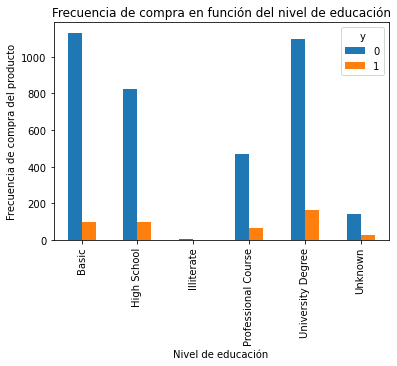

In [16]:
pd.crosstab(data.education,data.y).plot(kind="bar")
plt.title("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Proporción de clientes')

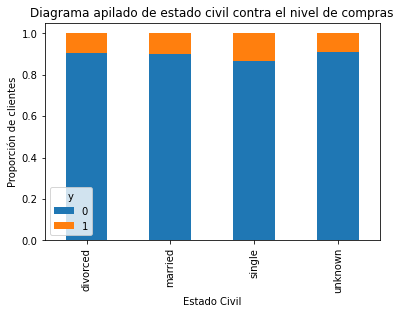

In [17]:
table = pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype("float"),axis=0).plot(kind="bar",stacked=True)
plt.title("Diagrama apilado de estado civil contra el nivel de compras")
plt.xlabel("Estado Civil")
plt.ylabel("Proporción de clientes")

Text(0, 0.5, 'Frecuencia de compra del producto')

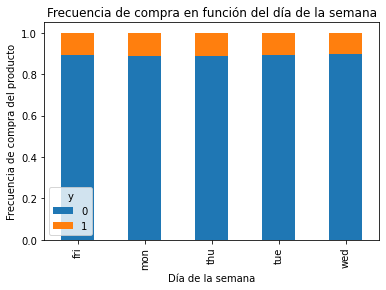

In [18]:
table = pd.crosstab(data.day_of_week,data.y)
table.div(table.sum(1).astype("float"),axis=0).plot(kind="bar",stacked=True)
plt.title("Frecuencia de compra en función del día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Frecuencia de compra del producto')

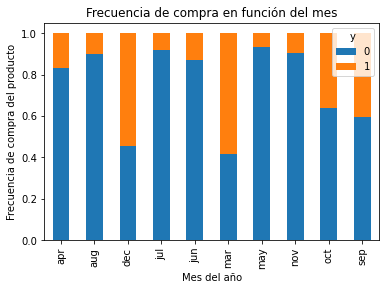

In [19]:
table = pd.crosstab(data.month,data.y)
table.div(table.sum(1).astype("float"),axis=0).plot(kind="bar",stacked=True)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Frecuencia de compra del producto')

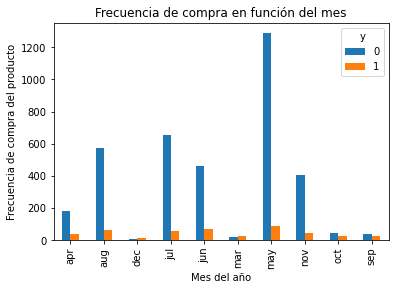

In [20]:
table = pd.crosstab(data.month,data.y)
table.plot(kind="bar",stacked=False)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Cliente')

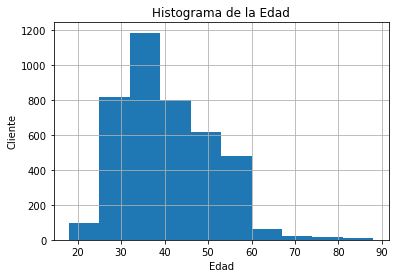

In [21]:
data.age.hist()
plt.title("Histograma de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cliente")

<AxesSubplot:xlabel='age'>

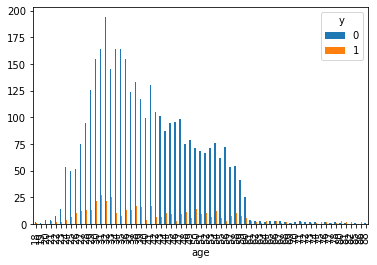

In [22]:
pd.crosstab(data.age,data.y).plot(kind="bar")

<AxesSubplot:xlabel='poutcome'>

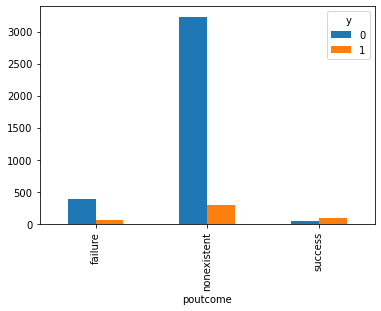

In [23]:
pd.crosstab(data.poutcome,data.y).plot(kind="bar")

In [24]:
data.isnull().mean()

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

### Conversión de las variables categóricas a dummies

In [25]:
categories = ["job", "marital", "education", "default", "housing", "loan", "contact", 
              "month", "day_of_week", "poutcome"]

for category in categories:
    cat_list = "cat" + "_" + category
    cat_dummies = pd.get_dummies(data[category], prefix=cat_list)
    data_new = data.join(cat_dummies)
    data = data_new

In [26]:
data_vars = data.columns.values.tolist()

In [27]:
to_keep = [v for v in data_vars if v not in categories]

In [28]:
bank_data = data[to_keep]
bank_data.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'cat_job_admin.', 'cat_job_blue-collar', 'cat_job_entrepreneur',
       'cat_job_housemaid', 'cat_job_management', 'cat_job_retired',
       'cat_job_self-employed', 'cat_job_services', 'cat_job_student',
       'cat_job_technician', 'cat_job_unemployed', 'cat_job_unknown',
       'cat_marital_divorced', 'cat_marital_married',
       'cat_marital_single', 'cat_marital_unknown', 'cat_education_Basic',
       'cat_education_High School', 'cat_education_Illiterate',
       'cat_education_Professional Course',
       'cat_education_University Degree', 'cat_education_Unknown',
       'cat_default_no', 'cat_default_unknown', 'cat_default_yes',
       'cat_housing_no', 'cat_housing_unknown', 'cat_housing_yes',
       'cat_loan_no', 'cat_loan_unknown', 'cat_loan_yes',
       'cat_contact_cellular', 'cat_contact_telephone', 'cat_month_apr',

In [29]:
bank_data_vars = bank_data.columns.values.tolist()
Y = ['y']
X = [v for v in bank_data_vars if v not in Y]

### Selección de rasgos para el modelo

In [30]:
n = 12

In [31]:
lr = LogisticRegression()

In [32]:
rfe = RFE(lr, n_features_to_select=n)
rfe = rfe.fit(bank_data[X], bank_data[Y].values.ravel())

C:\Users\msantamaria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\msantamaria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\msantamaria\anaconda3\lib

C:\Users\msantamaria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\msantamaria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\msantamaria\anaconda3\lib

In [33]:
print(rfe.support_)

[False False False False False False False False  True False False  True
  True False  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False  True  True  True
  True  True False False False False False False False False False False
  True]


In [34]:
print(rfe.ranking_)

[42 41 15 44 47 11 24 20  1 34  7  1  1 40  1  4  1 25 35  6  5 46 14 33
 32 49 23 12 48 17 30  3 29 31 50  8 16 43 13 18 26  1 10 37 19  1  1  1
  1  1 21 27 45 36 38 28 39  9  2 22  1]


In [35]:
z = zip(bank_data_vars, rfe.support_, rfe.ranking_)
z = list(z)
z_selected = [v for v in z if v[1] == True]
z_selected

[('euribor3m', True, 1),
 ('cat_job_admin.', True, 1),
 ('cat_job_blue-collar', True, 1),
 ('cat_job_housemaid', True, 1),
 ('cat_job_retired', True, 1),
 ('cat_loan_yes', True, 1),
 ('cat_month_aug', True, 1),
 ('cat_month_dec', True, 1),
 ('cat_month_jul', True, 1),
 ('cat_month_jun', True, 1),
 ('cat_month_mar', True, 1),
 ('cat_poutcome_nonexistent', True, 1)]

In [36]:
cols = [v[0] for v in z_selected]
cols

['euribor3m',
 'cat_job_admin.',
 'cat_job_blue-collar',
 'cat_job_housemaid',
 'cat_job_retired',
 'cat_loan_yes',
 'cat_month_aug',
 'cat_month_dec',
 'cat_month_jul',
 'cat_month_jun',
 'cat_month_mar',
 'cat_poutcome_nonexistent']

In [37]:
X = bank_data[cols]
Y = bank_data["y"]

### Implementación del modelo en Python con statsmodel.api

In [38]:
logit_model =sm.Logit(Y,X)

In [39]:
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.292178
         Iterations 7


In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4119
Model:                          Logit   Df Residuals:                     4107
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                  0.1542
Time:                        16:38:17   Log-Likelihood:                -1203.5
converged:                       True   LL-Null:                       -1422.9
Covariance Type:            nonrobust   LLR p-value:                 3.340e-87
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
euribor3m                   -0.5967      0.036    -16.553      0.000      -0.667      -0.526
cat_job_admin.               0.0150      0.119      0.126      0.900      -0.218       0.248
cat_job_blue-collar         -0.5509      0.152     -3.627      0.000      -0.849      -0.253
cat_job_housemaid            0.0483      0.348      0.139      0.890      -0.635       0.731
cat_job_retired              0.1981      0.219      0.903      0.366      -0.232       0.628
cat_loan_yes                -0.2470      0.150     -1.646      0.100      -0.541       0.047
cat_month_aug                0.4873      0.169      2.880      0.004       0.156       0.819
cat_month_dec                1.0574      0.446      2.370      0.018       0.183       1.932
cat_month_jul                0.9340      0.184      5.072      0.000       0.573       1.295
cat_month_jun                0.9789      0.170      5.773      0.000       0.647       1.311
cat_month_mar                1.5455      0.312      4.959      0.000       0.935       2.156
cat_poutcome_nonexistent    -0.6886      0.115     -5.978      0.000      -0.914      -0.463
============================================================================================
"""

### Implementación del modelo en Python con scikit-learn

In [41]:
cols = [v for v in cols if v not in ["cat_job_admin.","cat_job_housemaid","cat_job_retired"]]
cols

['euribor3m',
 'cat_job_blue-collar',
 'cat_loan_yes',
 'cat_month_aug',
 'cat_month_dec',
 'cat_month_jul',
 'cat_month_jun',
 'cat_month_mar',
 'cat_poutcome_nonexistent']

In [42]:
X = bank_data[cols]

In [43]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X,Y)

LogisticRegression()

In [44]:
logit_model.score(X,Y)

0.8953629521728574

In [45]:
1-Y.mean()

0.8905074047098811

In [46]:
pd.DataFrame(list(zip(X.columns, np.transpose(logit_model.coef_))))

,0,1
0,euribor3m,[-0.5435018823499432]
1,cat_job_blue-collar,[-0.42050790147846034]
2,cat_loan_yes,[-0.10813375319290296]
3,cat_month_aug,[0.6041027056164541]
4,cat_month_dec,[1.1371096576529722]
5,cat_month_jul,[0.9099802506678443]
6,cat_month_jun,[1.0090419821331593]
7,cat_month_mar,[1.6280968023684308]
8,cat_poutcome_nonexistent,[-0.4024968215221337]


## Validación del modelo logístico

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = .30,random_state=0)

In [48]:
lm = linear_model.LogisticRegression()
lm.fit(X_train,Y_train)

LogisticRegression()

In [49]:
display(Math(r'Y_p=\begin{cases}0& si\ p\leq0.5\\1&si\ p >0.5\end{cases}'))

<IPython.core.display.Math object>

In [50]:
probs = lm.predict_proba(X_test)

In [51]:
probs

array([[0.95510629, 0.04489371],
       [0.82806051, 0.17193949],
       [0.93080135, 0.06919865],
       ...,
       [0.67171442, 0.32828558],
       [0.97176395, 0.02823605],
       [0.49800011, 0.50199989]])

In [52]:
prediction = lm.predict(X_test)

In [53]:
prediction

array([0, 0, 0, ..., 0, 0, 1])

In [54]:
display(Math(r'\varepsilon\in (0,1), Y_p=\begin{cases}0& si\ p\leq \varepsilon\\1&si\ p >\varepsilon\end{cases}'))

<IPython.core.display.Math object>

In [55]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction"] = np.where(prob_df[0] > threshold, 1, 0)
prob_df.head()

,0,prediction
0,0.044894,0
1,0.171939,1
2,0.069199,0
3,0.064038,0
4,0.028014,0


In [56]:
pd.crosstab(prob_df["prediction"],columns="count")

col_0,count
prediction,
0,846
1,390


In [57]:
390/len(prob_df)*100

31.55339805825243

In [58]:
threshold = 0.15
prob_df["prediction"] = np.where(prob_df[0] > threshold, 1, 0)
pd.crosstab(prob_df.prediction,columns="count")

col_0,count
prediction,
0,896
1,340


In [59]:
340/len(prob_df)*100

27.508090614886733

In [60]:
threshold = 0.05
prob_df["prediction"] = np.where(prob_df[0] > threshold, 1, 0)
pd.crosstab(prob_df.prediction,columns="count")

col_0,count
prediction,
0,590
1,646


In [61]:
646/len(prob_df)*100

52.265372168284784

In [62]:
metrics.accuracy_score(Y_test,prediction)

0.9021035598705501

## Validación cruzada

In [63]:
scores = cross_val_score(linear_model.LogisticRegression(),X,Y,scoring="accuracy",cv=10)

In [64]:
scores

array([0.90291262, 0.88349515, 0.89805825, 0.8907767 , 0.89805825,
       0.89563107, 0.88834951, 0.89320388, 0.89563107, 0.89537713])

In [65]:
scores.mean()

0.8941493633808142

In [66]:
(1-(0.894/0.902))*100

0.8869179600886956

In [67]:
len(X_train), len(X_test)

(2883, 1236)

In [68]:
len(X_train) + len(X_test) == len(X)

True

## Matrices de Confusión y curvas ROC

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.3,random_state = 0)

In [70]:
lm = linear_model.LogisticRegression()
lm.fit(X_train,Y_train)

LogisticRegression()

In [71]:
probs = lm.predict_proba(X_test)

In [72]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction"] = np.where(prob_df[0] >= threshold, 1, 0)
prob_df["actual"] = list(Y_test)
prob_df

,0,prediction,actual
0,0.044894,0,0
1,0.171939,1,0
2,0.069199,0,0
3,0.064038,0,0
4,0.028014,0,0
...,...,...,...
1231,0.064038,0,0
1232,0.063971,0,0
1233,0.328286,1,0
1234,0.028236,0,0


In [73]:
confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
confusion_matrix

actual,0,1
prediction,,
0,806,40
1,308,82


In [74]:
TN = confusion_matrix[0][0]
TP = confusion_matrix[1][1]
FN = confusion_matrix[1][0]
FP = confusion_matrix[0][1]

In [75]:
sens = TP/(TP+FN)
sens

0.6721311475409836

In [76]:
espec_1 = 1 - (TN/(TN+FP))
espec_1

0.2764811490125674

In [77]:
thresholds = [0.04,0.05,0.07,0.10,0.12,0.15,0.18,0.20,0.25,0.3,0.4,0.5]
sensitivities = [1]
specifities_1 = [1]

for t in thresholds:        
    prob_df["prediction"] = np.where(prob_df[0] >= t, 1, 0)
    prob_df["actual"] = list(Y_test)
    prob_df

    confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FN = confusion_matrix[1][0]
    FP = confusion_matrix[0][1]

    sens = TP/(TP+FN)
    spec_1 = 1 - (TN/(TN+FP))
    
    sensitivities.append(sens)
    specifities_1.append(spec_1)
    
sensitivities.append(0)
specifities_1.append(0)

In [78]:
sensitivities

[1,
 0.9262295081967213,
 0.7868852459016393,
 0.6721311475409836,
 0.6721311475409836,
 0.6721311475409836,
 0.6557377049180327,
 0.5327868852459017,
 0.4918032786885246,
 0.4262295081967213,
 0.36065573770491804,
 0.16393442622950818,
 0.10655737704918032,
 0]

In [79]:
specifities_1

[1,
 0.7666068222621185,
 0.4937163375224417,
 0.2800718132854578,
 0.2764811490125674,
 0.25763016157989227,
 0.23339317773788149,
 0.13195691202872528,
 0.1202872531418312,
 0.08797127468581689,
 0.05924596050269304,
 0.024236983842010784,
 0.010771992818671472,
 0]

Text(0.5, 1.0, 'Curva ROC')

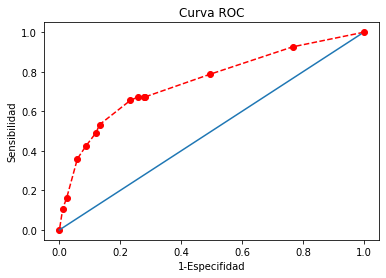

In [80]:
plt.plot(specifities_1,sensitivities,marker="o",linestyle="--",color="r")
x = [i*0.01 for i in range(100)]
y = [i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")

In [81]:
prob

array([0.04489371, 0.17193949, 0.06919865, ..., 0.32828558, 0.02823605,
       0.50199989])

In [82]:
spec_1, sensit, _ = metrics.roc_curve(Y_test,prob)

In [83]:
sensit

array([0.        , 0.00819672, 0.02459016, 0.02459016, 0.05737705,
       0.05737705, 0.08196721, 0.08196721, 0.09836066, 0.09836066,
       0.10655738, 0.10655738, 0.1147541 , 0.1147541 , 0.1147541 ,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.13934426,
       0.13934426, 0.1557377 , 0.1557377 , 0.17213115, 0.17213115,
       0.18032787, 0.18032787, 0.21311475, 0.21311475, 0.23770492,
       0.24590164, 0.24590164, 0.2704918 , 0.27868852, 0.29508197,
       0.29508197, 0.29508197, 0.29508197, 0.29508197, 0.29508197,
       0.30327869, 0.30327869, 0.31147541, 0.31147541, 0.32786885,
       0.3442623 , 0.3442623 , 0.3442623 , 0.36065574, 0.36065574,
       0.36885246, 0.3852459 , 0.3852459 , 0.3852459 , 0.40163934,
       0.40163934, 0.40983607, 0.40983607, 0.40983607, 0.40983607,
       0.41803279, 0.42622951, 0.42622951, 0.42622951, 0.42622951,
       0.43442623, 0.43442623, 0.44262295, 0.44262295, 0.44262295,
       0.44262295, 0.44262295, 0.45081967, 0.45081967, 0.47540

In [84]:
df = pd.DataFrame({
    "x":spec_1,
    "y":sensit
})

In [85]:
df.head()

,x,y
0,0.000000,0.000000
1,0.000898,0.008197
2,0.000898,0.024590
3,0.002693,0.024590
4,0.002693,0.057377


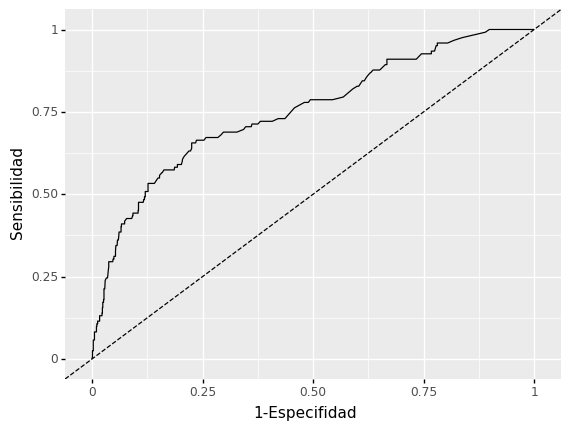

<ggplot: (187352211342)>

In [86]:
ggplot(df, aes(x="x", y="y")) + geom_line() + geom_abline(linetype="dashed") + xlim(-0.01,1.01) + ylim(-0.01,1.01) + xlab("1-Especifidad") + ylab("Sensibilidad")

In [87]:
auc = metrics.auc(spec_1,sensit)
auc

0.7526856402860758

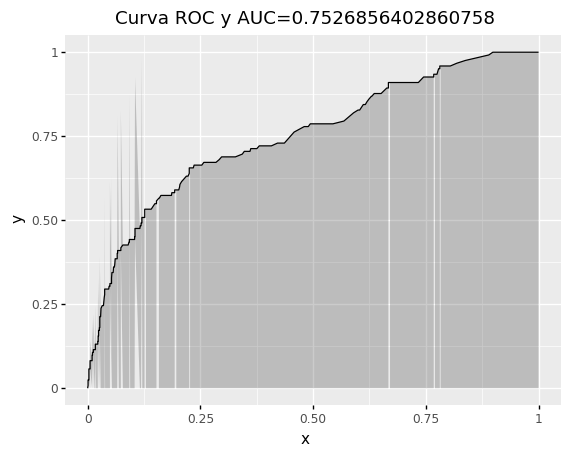

<ggplot: (187355817897)>

In [92]:
ggplot(df,aes(x="x",y="y")) + geom_area(alpha=0.25) + geom_line(aes(y="y")) + ggtitle("Curva ROC y AUC=%s" % str(auc)) + ylim(0,1)